<a href="https://colab.research.google.com/github/alrz199/autoencoders/blob/main/Deep_AE_FASHION_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a deep autoencoder using FashionMnist data, the goal is to get noisy inputs and denoise them

In [1]:
!pip --quiet install pytorch_lightning pytorch_forecasting

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
batch_size=64
transform = transforms.Compose(
    [transforms.ToTensor()])
# Fashion mnist
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 15970088.81it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 289908.25it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5139830.92it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18973881.36it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



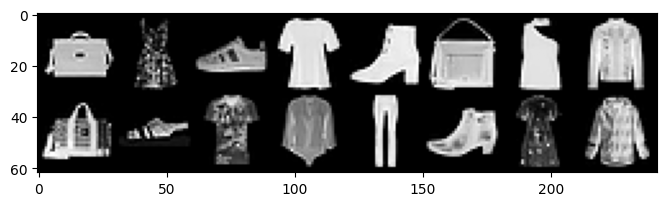

In [4]:
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images[0:16]))

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

In [6]:
import pytorch_lightning as pl
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# our deep autoencoder
learning_rate=0.005
class nnn(pl.LightningModule):

    def __init__(self):
        super().__init__()
        latent_dim = 16
        c_hid = 2
        act_fn = nn.LeakyReLU
        # encoder is a stack of conv2d layers with a linear layer at the end
        self.encoder = nn.Sequential(
            nn.Conv2d(1, c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(4*7*7, latent_dim))
        # for decoder, we will use con2dTransposed to increase the size of the
        # image and we will utilize conv2d to extract information after each resizing
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(1, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, 1, kernel_size=3, output_padding=1, padding=3, stride=2),
            act_fn(),
            nn.Tanh()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(x.shape[0], -1 , 4,4)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
      # we will add noise to the input and ask our model to denoise the data
        x, y = batch
        noise=torch.randn(x.size()) * 0.15
        x1 = x + noise.to(device)
        out=self.forward(x1)
        x = x.view(-1,28*28)
        out = out.view(-1,28*28)
        loss = F.mse_loss(out,x)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        noise=torch.randn(x.size()) * 0.15
        x1 = x + noise.to(device)
        out=self.forward(x1)
        x = x.view(-1,28*28)
        out = out.view(-1,28*28)
        loss = F.mse_loss(out,x)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
  #   def configure_optimizers(self):
  #       optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
        # return {
        # "optimizer": optimizer,
        # "lr_scheduler": {
        #   "scheduler":  torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)}}


In [7]:
# Initialize a trainer
from pytorch_lightning import  Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="my_model")
model=nnn()
trainer = Trainer(
    accelerator="auto",
    max_epochs=10,callbacks=[EarlyStopping(monitor="val_loss")])

# Train the model ⚡
trainer.fit(model, train_loader,val_dataloaders=test_loader)
print('Finished Training')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 3.4 K 
1 | decoder | Sequential | 319   
---------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Finished Training


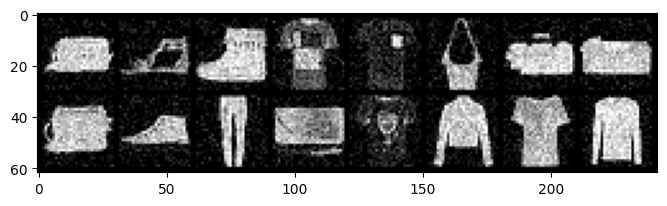

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
noise=torch.randn(images[1:17].size()) * 0.1 + 0
# show images
imshow(torchvision.utils.make_grid(images[1:17]+noise))

In [ ]:
model(images)

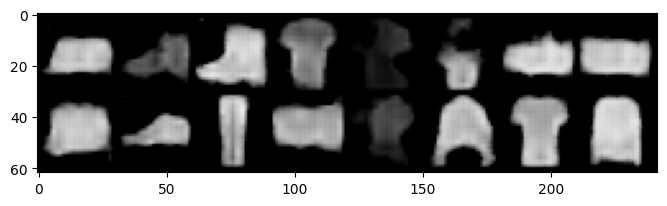

In [10]:
# let's check the performance of the model on these pics
imshow(torchvision.utils.make_grid(model(images[1:17])))

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/